In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np 


In [ ]:
path = '/content/drive/MyDrive/IodineExfiltrationAttackFQDNs.csv'
df = pd.read_csv(path, header=None, names=['Encoded data'])
df.describe

<bound method NDFrame.describe of                                               Encoded data
0        b'0zaat\xde\xd0w4\xe4j\xef\xd6\xdfA\xfc\xcfY\x...
1        b'0zaabV2k5jsl\xbf\xecg\xc9\xddY\xe6e\xfcd\xdb...
2        b'0izacY\xd3\xd3\xd4\xfabbw07hU\xc6u9\xdd\xfb\...
3        b'0yhbp82\xbey\xeeb\xe1\xfdaabacuaa\xc31s\xd2a...
4        b'0qja7\xe2\xc3tpbae\xedQW\xf9pfZ\xc36\xc1j3\x...
...                                                    ...
2284059  b'0q0a7\xc5\xd8\xc6\xcb\xebUp\xdd\xe2\xc8h\xf6...
2284060  b'0i2aw\xdc\xeb\xd9T\xf2\xd0\xc7h\xbdEt\xdar8t...
2284061  b'0qgat82\xbew\xeesJ\xf9aabacuqe1FPuabag\xc6\x...
2284062  b'0veacfOz\xcf\xe9\xc3\xc6LqSJ\xe3V\xf2\xd0N\x...
2284063  b'0ega582\xbew\xeesJ\xf9aabacuqe1rv\xe2abag\xe...

[2284064 rows x 1 columns]>

For our evaluation, let us take a sample size of 200,000

In [ ]:
newDf = df.sample(n=250000, random_state=8)
newDf.astype(str)
newDf

,Encoded data
701735,b'0mtal\xe1NaV\xfa5\xc3Q\xc9\xfc\xc6\xc9Wp\xfc...
1701229,b'0bkblO\xf4\xefQn\xd5\xe5iK5\xebHa\xcc\xed\xe...
2185313,b'02vax7\xc00v\xcf\xd4\xbc1\xf2dvH\xcb\xefcis\...
1918725,b'0mvah\xec\xc4r\xbf\xc8\xf1epWI0C\xdb\xd8X\xe...
2051297,b'0alaj\xe2\xde\xd7t\xf0\xfc2\xear\xf9\xe8\xf1...
...,...
117122,b'0faa4iC\xfc\xe7\xd4\xc0f\xc4\xe4J\xbcZ\xfc\x...
1679625,b'03obq\xceSq\xd0l\xd4\xe3\xd8\xc5y\xfc\xfb\xe...
2134408,b'0adb082\xca2hb\xbe\xee\xf0\xd6gjk\xfd\xc1\xb...
2109579,b'02mad\xc0Q\xbf\xc6D\xe3\xd1\xd4zK\xfc\xc6\xf...


In [ ]:
newDf = newDf.reset_index(drop=True)
newDf

,Encoded data
0,b'0mtal\xe1NaV\xfa5\xc3Q\xc9\xfc\xc6\xc9Wp\xfc...
1,b'0bkblO\xf4\xefQn\xd5\xe5iK5\xebHa\xcc\xed\xe...
2,b'02vax7\xc00v\xcf\xd4\xbc1\xf2dvH\xcb\xefcis\...
3,b'0mvah\xec\xc4r\xbf\xc8\xf1epWI0C\xdb\xd8X\xe...
4,b'0alaj\xe2\xde\xd7t\xf0\xfc2\xear\xf9\xe8\xf1...
...,...
249995,b'0faa4iC\xfc\xe7\xd4\xc0f\xc4\xe4J\xbcZ\xfc\x...
249996,b'03obq\xceSq\xd0l\xd4\xe3\xd8\xc5y\xfc\xfb\xe...
249997,b'0adb082\xca2hb\xbe\xee\xf0\xd6gjk\xfd\xc1\xb...
249998,b'02mad\xc0Q\xbf\xc6D\xe3\xd1\xd4zK\xfc\xc6\xf...


Let us create features for our dataset

**Now let us create some helper funtions to obtain our features**

In [ ]:
# function to count the number of digits
def numOfDigits(input_string):
  d=0
  for c in input_string:
    if c.isdigit():
        d=d+1
    else:
      pass
  return d

In [ ]:
import re

def countUppercase(input_string):
  count = len(re.findall(r'[A-Z]',input_string))
  return count


In [ ]:
# count of labels in DNS query
def numOfLables(input_query):
    d=0
    for c in input_query:
        if c == '.':
            d+=1
    return d

In [ ]:
# fucntion to calculate the length of the subdomain
def countOfCharsinSubdomain(input_query):
  return len(input_query) - 28

In [ ]:
# fucntion to calculate the average length of the labels
from statistics import mean

def AvgLengthOfLabels(input_query):
  query_list = input_query.split('.')
  return(mean([len(i) for i in query_list]))
  

In [ ]:
# function to calculate shannons entrophy
import math
def find_entropy(input_query):
    if not input_query: 
        return 0 
    entropy = 0
    for x in range(256): 
        p_x = float(input_query.count(chr(x)))/len(input_query) 
        if p_x > 0: 
            entropy += - p_x*math.log(p_x, 2) 
    return entropy

Now, let us split the data into train and test

In [ ]:
# split the large dataset into train and test
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(newDf, test_size = 0.3, random_state=55)
# Look at the shape of the outputs
print(X_train.shape)
print(X_test.shape)

(175000, 1)
(75000, 1)


In [ ]:
X_test.isna().any().any()

False

**Preprocessing the training data**

In [ ]:
# temp table
columns = ['Encoded_data', 'Length_of_Subdomain', 'Number_of_Labels', 'Average_length_of_Labels', 'Count_of_Numbers', 'Count_of_UpperCase', 'Entrophy' ]
tempFeatures = pd.DataFrame(columns=columns)
tempFeatures

,Encoded_data,Length_of_Subdomain,Number_of_Labels,Average_length_of_Labels,Count_of_Numbers,Count_of_UpperCase,Entrophy


In [ ]:
for index, row in X_train.iterrows():
  tempFeatures = tempFeatures.append({"Encoded_data": row[0],
                                      "Length_of_Subdomain": countOfCharsinSubdomain(row[0]),
                                      "Number_of_Labels": numOfLables(row[0]), 
                                      "Average_length_of_Labels": AvgLengthOfLabels(row[0]), 
                                      "Count_of_Numbers": numOfDigits(row[0]) ,
                                      "Count_of_UpperCase": countUppercase(row[0]),
                                      "Entrophy": find_entropy(row[0])}, ignore_index=True)

In [ ]:
X_train = tempFeatures.copy()


In [ ]:
X_train

,Encoded_data,Length_of_Subdomain,Number_of_Labels,Average_length_of_Labels,Count_of_Numbers,Count_of_UpperCase,Entrophy
0,b'03aaq\xf2\xbeG\xc7\xe0\xc9\xcc\xca9N\xe1D\xe...,583,7,75.500,78,54,4.389699
1,b'0ihav82\xbew\xeesJ\xf9aabacuqe1nZ\xd2abag\xe...,511,7,66.500,72,40,4.530118
2,b'0fkb4Q\xecDFN\xe8H\xc4OmZ\xd3D1\xc1\xbd\xd9\...,470,7,61.375,82,38,4.469136
3,b'0qua4U\xbf\xddOgB\xce\xfdf\xe1\xd6M\xf9\xf9G...,562,7,72.875,75,49,4.481219
4,b'0ema3EX\xca3\xf1QK\xd8\xd62\xd6Se\xef\xe3En\...,598,7,77.375,96,41,4.311626
...,...,...,...,...,...,...,...
174995,b'0q0ah\xebb6\xe5\xd3\xc1m\xcb\xcf\xd6\xe90\xf...,577,7,74.750,89,49,4.426524
174996,b'0vkbry\xf4Pij\xd5\xfb\xf1\xe9\xd7\xf0\xc2AFc...,476,7,62.125,74,38,4.493035
174997,b'02va4H\xda\xc6Ewn\xe7\xf6\xe8y\xf3\xca\xca2\...,601,7,77.750,105,41,4.335566
174998,b'0bkb5\xca\xdftO\xdd\xebo\xc4iVj\xfdn\xf94Y\x...,518,7,67.375,69,36,4.230303


In [ ]:
X_train.to_csv("/content/drive/MyDrive/Train_Data.csv", index=False)

In [3]:
X_train = pd.read_csv("/content/drive/MyDrive/Train_Data.csv")

Let us explore our features

In [ ]:
X_train['Number_of_Labels'].nunique()

4

7    166767
6      4246
5      3560
4       427
Name: Number_of_Labels, dtype: int64


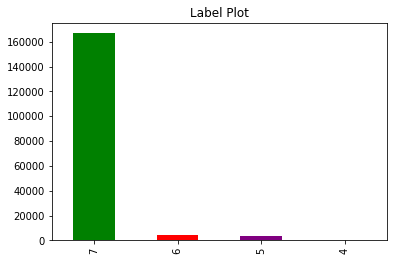

In [18]:
import matplotlib.pyplot as plt
counts = X_train['Number_of_Labels'].value_counts()
print(counts)
counts.plot(kind = 'bar',color = ["green","red", "purple", "yellow"])
plt.title('Label Plot')
plt.show()


This is understandable because most DNS attacks are encrypted, and longer DNS queries are indicative of data being exfiltrated

In [ ]:
X_train['Count_of_UpperCase'].nunique()

73

In [ ]:
X_train['Average_length_of_Labels'].describe()

count    175000.000000
mean         70.601474
std           8.795603
min           8.600000
25%          67.000000
50%          72.875000
75%          75.875000
max          87.875000
Name: Average_length_of_Labels, dtype: float64

From this, we can see that the dns queries have similar label length

In [ ]:
null_data = X_train[X_train.isnull().any(axis=1)]

In [ ]:
null_data

,Encoded_data,Length_of_Subdomain,Number_of_Labels,Average_length_of_Labels,Count_of_Numbers,Count_of_UpperCase,Entrophy


In [4]:
X_train.isnull().sum().sum()

0

**Feature Enginieering done**

Let us obtain oly the features of our dataset to buil a ML model

In [5]:
train_data = X_train[['Length_of_Subdomain', 'Number_of_Labels',
       'Average_length_of_Labels', 'Count_of_Numbers', 'Count_of_UpperCase',
       'Entrophy']]
train_data

,Length_of_Subdomain,Number_of_Labels,Average_length_of_Labels,Count_of_Numbers,Count_of_UpperCase,Entrophy
0,583,7,75.500,78,54,4.389699
1,511,7,66.500,72,40,4.530118
2,470,7,61.375,82,38,4.469136
3,562,7,72.875,75,49,4.481219
4,598,7,77.375,96,41,4.311626
...,...,...,...,...,...,...
174995,577,7,74.750,89,49,4.426524
174996,476,7,62.125,74,38,4.493035
174997,601,7,77.750,105,41,4.335566
174998,518,7,67.375,69,36,4.230303


**Preprocessing the test data**

In [ ]:
# temp table
columns = ['Encoded_data', 'Length_of_Subdomain', 'Number_of_Labels', 'Average_length_of_Labels', 'Count_of_Numbers', 'Count_of_UpperCase', 'Entrophy' ]
tempFeatures2 = pd.DataFrame(columns=columns)
tempFeatures2

,Encoded_data,Length_of_Subdomain,Number_of_Labels,Average_length_of_Labels,Count_of_Numbers,Count_of_UpperCase,Entrophy


In [ ]:
for index, row in X_test.iterrows():
  tempFeatures2 = tempFeatures2.append({"Encoded_data": row[0],
                                      "Length_of_Subdomain": countOfCharsinSubdomain(row[0]),
                                      "Number_of_Labels": numOfLables(row[0]), 
                                      "Average_length_of_Labels": AvgLengthOfLabels(row[0]), 
                                      "Count_of_Numbers": numOfDigits(row[0]) ,
                                      "Count_of_UpperCase": countUppercase(row[0]),
                                      "Entrophy": find_entropy(row[0])}, ignore_index=True)
 

In [ ]:
tempFeatures2

,Encoded_data,Length_of_Subdomain,Number_of_Labels,Average_length_of_Labels,Count_of_Numbers,Count_of_UpperCase,Entrophy
0,b'0qoacY2\xeeAH\xd4m\xd0\xd7\xf6\xdb\xf0\xbd\x...,592,7,76.625,91,45,4.356736
1,b'0yqa8\xcf\xc9\xd3JiG\xbe\xee\xf8uV\xe9\xc8\x...,613,7,79.250,95,47,4.268468
2,b'0vjbdv\xd2b\xc738\xe2L\xe3B\xc1\xebL\xee\xbf...,476,7,62.125,78,35,4.393889
3,b'0ucat82\xbew\xeesJ\xf9aabacuqe1DxKabag\xca\x...,499,7,65.000,59,55,4.627084
4,b'0ula5Zo\xd8\xfdfg\xf5\xf8\xea\xe4W\xcci\xd0\...,538,7,69.875,73,53,4.527153
...,...,...,...,...,...,...,...
74995,b'0bjbst\xe048\xd9\xc6\xd8K\xf8\xd3\xd2I\xc8YJ...,461,7,60.250,83,42,4.533155
74996,b'0eeah82\xbew\xeesJ\xf9aabacuqe1m\xc1Kabag\xe...,499,7,65.000,85,48,4.656191
74997,b'0bcal\xed5k\xcd0M\xdb\xf6X\xde\xc1U\xe1ZG\xe...,583,7,75.500,100,49,4.393216
74998,b'0i2a7d\xe8r\xd6\xe4\xc4\xbc4S\xe9\xe6\xdf\xc...,598,7,77.375,96,35,4.299324


In [ ]:
X_test =  tempFeatures2.copy()

In [ ]:
X_test

,Encoded_data,Length_of_Subdomain,Number_of_Labels,Average_length_of_Labels,Count_of_Numbers,Count_of_UpperCase,Entrophy
0,b'0qoacY2\xeeAH\xd4m\xd0\xd7\xf6\xdb\xf0\xbd\x...,592,7,76.625,91,45,4.356736
1,b'0yqa8\xcf\xc9\xd3JiG\xbe\xee\xf8uV\xe9\xc8\x...,613,7,79.250,95,47,4.268468
2,b'0vjbdv\xd2b\xc738\xe2L\xe3B\xc1\xebL\xee\xbf...,476,7,62.125,78,35,4.393889
3,b'0ucat82\xbew\xeesJ\xf9aabacuqe1DxKabag\xca\x...,499,7,65.000,59,55,4.627084
4,b'0ula5Zo\xd8\xfdfg\xf5\xf8\xea\xe4W\xcci\xd0\...,538,7,69.875,73,53,4.527153
...,...,...,...,...,...,...,...
74995,b'0bjbst\xe048\xd9\xc6\xd8K\xf8\xd3\xd2I\xc8YJ...,461,7,60.250,83,42,4.533155
74996,b'0eeah82\xbew\xeesJ\xf9aabacuqe1m\xc1Kabag\xe...,499,7,65.000,85,48,4.656191
74997,b'0bcal\xed5k\xcd0M\xdb\xf6X\xde\xc1U\xe1ZG\xe...,583,7,75.500,100,49,4.393216
74998,b'0i2a7d\xe8r\xd6\xe4\xc4\xbc4S\xe9\xe6\xdf\xc...,598,7,77.375,96,35,4.299324


In [ ]:
X_test.to_csv("/content/drive/MyDrive/Test_Data.csv", index=False)

In [6]:
X_test = pd.read_csv("/content/drive/MyDrive/Test_Data.csv")# tag it 

In [7]:
X_test.isnull().sum().sum()

0

In [8]:
test_data = X_test[['Length_of_Subdomain', 'Number_of_Labels',
       'Average_length_of_Labels', 'Count_of_Numbers', 'Count_of_UpperCase',
       'Entrophy']]
test_data

,Length_of_Subdomain,Number_of_Labels,Average_length_of_Labels,Count_of_Numbers,Count_of_UpperCase,Entrophy
0,592,7,76.625,91,45,4.356736
1,613,7,79.250,95,47,4.268468
2,476,7,62.125,78,35,4.393889
3,499,7,65.000,59,55,4.627084
4,538,7,69.875,73,53,4.527153
...,...,...,...,...,...,...
74995,461,7,60.250,83,42,4.533155
74996,499,7,65.000,85,48,4.656191
74997,583,7,75.500,100,49,4.393216
74998,598,7,77.375,96,35,4.299324


**Since our dataset contains data for only one class. We shall use the one-class SVM**

In [ ]:
from sklearn.svm import OneClassSVM

In [ ]:
x = train_data.values

In [ ]:
len(x)

175000

In [ ]:
clf = OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
#clf = OneClassSVM(nu=0.1, kernel="rbf", gamma=0.003)

In [ ]:
from sklearn.metrics import recall_score
# since it is a one class svm, we will use recall as our evaluation measure
clf.fit(train_data)
pred = clf.predict(train_data)

In [ ]:
# extract the negative outputs as the outliers
from numpy import  where
outlier_index = where(pred==-1)
outliers = x[outlier_index]

In [ ]:
len(outliers)

19142

There were 19,142 misclassifed records

We will only be able to find the recall (TP/(TP+FN)), since we only have positive documents that can be classified as true positives (TP, i.e., OCSVM got it right) or false negatives (FN, i.ie, the OCSVM was wrong).

In [ ]:

print("Recall for the training data is: " +  str((len(x) -len(outliers))/len(x)))

Recall for the training data is: 0.8906171428571429


In [ ]:
y =test_data.values

In [ ]:
test_pred = clf.predict(test_data)

In [ ]:
outlier_index = where(test_pred==-1)
outliers = y[outlier_index]

In [ ]:
len(outliers)

10396

In [ ]:
print("Recall for the test data is: " +  str((len(y) -len(outliers))/len(y)))

Recall for the test data is: 0.8613866666666666


**Due to some features being significantly larger than others, let us try normalizing the features**

In [ ]:
# data normalization with sklearn
from sklearn.preprocessing import MinMaxScaler
# fit scaler on training data
norm = MinMaxScaler().fit(train_data)
# transform training data
X_train_norm = norm.transform(train_data)

In [ ]:
X_train_norm

array([[0.85067873, 1.        , 0.84389782, 0.64705882, 0.73611111,
        0.42834596],
       [0.74208145, 1.        , 0.73036897, 0.59663866, 0.54166667,
        0.57258565],
       [0.68024133, 1.        , 0.66572059, 0.68067227, 0.51388889,
        0.50994446],
       ...,
       [0.87782805, 1.        , 0.87228004, 0.87394958, 0.55555556,
        0.37274   ],
       [0.75263952, 1.        , 0.7414065 , 0.57142857, 0.48611111,
        0.26461273],
       [0.92307692, 1.        , 0.91958373, 0.75630252, 0.56944444,
        0.25302407]])

In [ ]:
clf = OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)

In [ ]:
clf.fit(X_train_norm)
pred = clf.predict(X_train_norm)

In [ ]:
# extract the negative outputs as the outliers
from numpy import  where
outlier_index = where(pred==-1)
outliers = X_train_norm[outlier_index]

In [ ]:
len(outliers)

17500

In [ ]:
print("Recall for the normalized training data is: " +  str((len(X_train_norm) -len(outliers))/len(X_train_norm)))

Recall for the normalized training data is: 0.9


In [ ]:
X_test_norm = norm.transform(test_data)

In [ ]:
pred = clf.predict(X_test_norm)

In [ ]:
# extract the negative outputs as the outliers
from numpy import  where
outlier_index = where(pred==-1)
outliers = X_test_norm[outlier_index]

In [ ]:
len(outliers)

7469

In [ ]:
print("Recall for the normalized test data is: " +  str((len(X_test_norm) -len(outliers))/len(X_test_norm)))

Recall for the normalized test data is: 0.9004133333333333


From this we can see that the normalized dataset perfromed slightly better than the unnormalized dataset.
We obtain a recall of 0.9 for the one-class SVM.

##**iForest**

In [15]:
 from sklearn.ensemble import IsolationForest

Let us start with small values of our hyperparamenters.
We have n-estimators set to 2, and we test for 1-20 for height of trees. 

In [49]:
# This function trains and tests given datasets and returns a list of recall scores
def train_and_evaluate(train, test):
  train_scores = []
  test_scores = []
  for i in range (1, 20):
    print("Start training")
    print("iForest with " + str(i) + " trees")
    clf = IsolationForest(n_estimators=2, max_samples=i, contamination=float(0.1), random_state=0)
    x=train.values
    clf.fit(x)
    pred= clf.predict(x)
    from numpy import  where
    outlier_index = where(pred==-1)
    outliers = x[outlier_index]
    score = (len(train) -len(outliers))/len(train)
    train_scores.append(score)
    y = test.values
    y_pred = clf.predict(y)
    outlier_index = where(y_pred==-1)
    outliers = y[outlier_index]
    score_test = (len(test) -len(outliers))/len(test)
    test_scores.append(score_test)
    print("Done training")
  return train_scores, test_scores


In [71]:
# Plots the train and the test scores
def plotScores(scores_train, scores_test):
    # Plot the points
    plt.figure(figsize=(10, 6))
    plt.plot([i+1 for i in range(len(scores_train))], scores_train)
    plt.plot([i+1 for i in range(len(scores_test))], scores_test)
    # Setup the legend
    plt.legend(["Train scores", "Test Scores"])
    # Labels for the x and y axis
    plt.ylabel("Recall")
    plt.xlabel("Iteration")
    plt.show()

In [74]:
tain_scores, test_scores = train_and_evaluate(train_data,test_data)

Start training
iForest with 1 trees
Done training
Start training
iForest with 2 trees
Done training
Start training
iForest with 3 trees
Done training
Start training
iForest with 4 trees
Done training
Start training
iForest with 5 trees
Done training
Start training
iForest with 6 trees
Done training
Start training
iForest with 7 trees
Done training
Start training
iForest with 8 trees
Done training
Start training
iForest with 9 trees
Done training
Start training
iForest with 10 trees
Done training
Start training
iForest with 11 trees
Done training
Start training
iForest with 12 trees
Done training
Start training
iForest with 13 trees
Done training
Start training
iForest with 14 trees
Done training
Start training
iForest with 15 trees
Done training
Start training
iForest with 16 trees
Done training
Start training
iForest with 17 trees
Done training
Start training
iForest with 18 trees
Done training
Start training
iForest with 19 trees
Done training


In [70]:
print(len(tain_scores))

19


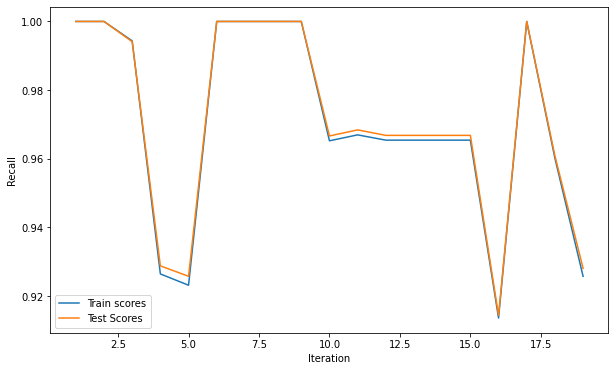

In [72]:
plotScores(tain_scores, test_scores)

**As we can see from the graph above recall scores for the test and train data peak at the fifth iteration , i.e where max_samples=6. Therefore our algorithm would have n_estimators=2, max_samples=6:, contamination=float(0.1)**

**The iForest algorithm perfoms better with a recall of 100% compared to a recall of 90% for the one-class SVM**